# Stabilization of Predator Prey Interactions

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

COLOR_PALETTE = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

Let us begin with a prey species model.

$$\frac{dR}{dt} = rR$$

Each unit in our population $R$ produces growth at a rate $r$. 

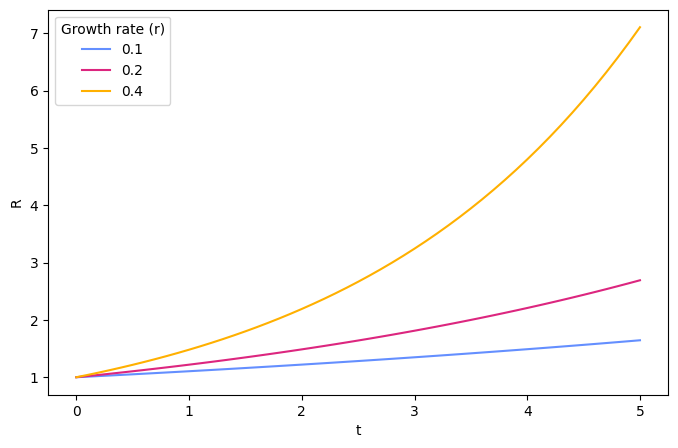

In [41]:
def simulate(r, R, N, dt):
    R_arr = [R]
    for _ in range(N):
        R = R + r * R * dt
        R_arr.append(R)

    return pd.DataFrame({'R': R_arr, 't': np.arange(0, N+1)*dt})

plt.figure(figsize=(8, 5))
for r, color in zip([0.1, 0.2, 0.4], COLOR_PALETTE[::2]):
    df = simulate(r=r, R=1, N=50, dt=0.1)
    sns.lineplot(x='t', y='R', data=df, color=color, label=f"{r}")
plt.legend(title="Growth rate (r)", loc="upper left");


This gives us exponential growth. However all creatures eventually hit some kind of carrying capacity ($K$). Therefore we will modify our model to make growth zero at $K$. 

$$\frac{dR}{dt} = \left(1 - R/K \right)rR$$

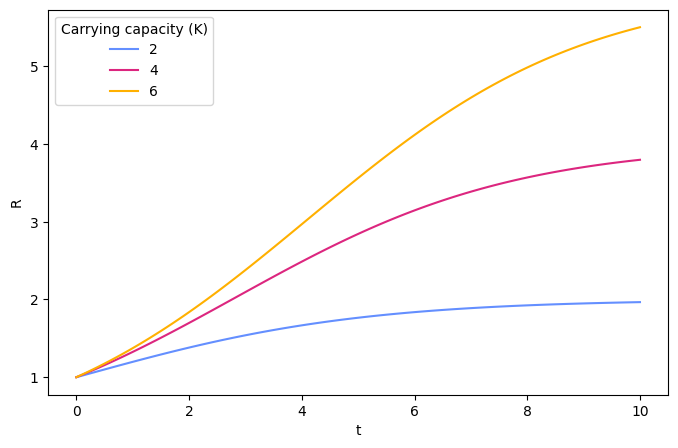

In [52]:
def simulate(r, R, N, dt, K):
    R_arr = [R]
    for _ in range(N):
        R = R + (1 - R / K) * r * R * dt
        R_arr.append(R)

    return pd.DataFrame({'R': R_arr, 't': np.arange(0, N+1)*dt})

plt.figure(figsize=(8, 5))
for K, color in zip([2, 4, 6], COLOR_PALETTE[::2]):
    df = simulate(r=0.4, R=1, N=100, dt=0.1, K=K)
    sns.lineplot(x='t', y='R', data=df, color=color, label=f"{K}")
plt.legend(title="Carrying capacity (K)", loc="upper left");

Let us now model our predator. There are two parts. (1) How does the predator reduce the prey and (2) how does the predator itself grow. If the prey is very abundant, relative to the predator, then each predator will consume the maximum it can ($z$). As the prey becomes virtually absent the predator approach 0 consumption. We can therefore model the consumption rate per predator $C$ as:

$$\frac{z}{1 + \alpha C / R}$$

where $\alpha$ determines how sensitive the consumption rate is to the relative abundance of predator and prey. 

Our prey model is now:

$$\frac{dR}{dt} = \left(1 - R/K \right)rR - \frac{z}{1 + \alpha C / R}C$$

On the predator side if we assume that $b$ is the efficiency at which a predator can turn what it has consumed into growth and $m$ is the base "metabolic" requirement to stay alive we have:

$$\frac{dC}{dt} = \frac{z}{1-\alpha C / R}C b - mC$$

Trying to get a visual sense for this is harder than for the prior single species models. So we will take advantage of isoclines. Isoclines are the points at which the growth rates are zero for either species. 

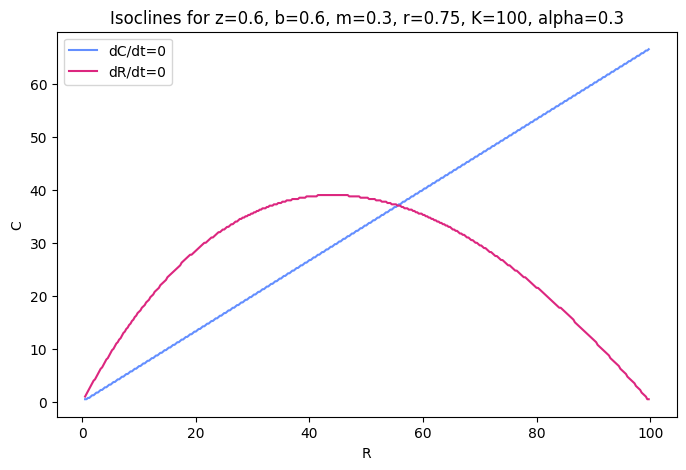

In [75]:
def build_isoclines(C_range, R_range, z, b, m, r, K, alpha, response=lambda R: 1.0):
    C, R = np.meshgrid(np.arange(*C_range), np.arange(*R_range))
    divisor = 1 + alpha * C / R 
    dC = (response(R) * z * b / divisor - m) * C 
    dR = r * (1 - R / K) * R - response(R) * z / divisor * C

    # hold R fixed and vary C looking for the dR closest to 0
    R_isocline_indices = np.argmin(np.abs(dR), axis=1) + np.arange(0, dR.shape[1] * dR.shape[0], dR.shape[1])
    # hold R fixed and vary C looking for the dC closest to 0
    C_isocline_indices = np.argmin(np.abs(dC), axis=1) + np.arange(0, dC.shape[1] * dC.shape[0], dC.shape[1])
    C_isocline = pd.DataFrame({'C': C.flatten()[C_isocline_indices], 'R': R.flatten()[C_isocline_indices], 'd': dC.flatten()[C_isocline_indices]})
    C_isocline['case'] = 'C'
    R_isocline = pd.DataFrame({'C': C.flatten()[R_isocline_indices], 'R': R.flatten()[R_isocline_indices], 'd': dR.flatten()[R_isocline_indices]})
    R_isocline['case'] = 'R'
    return pd.concat([C_isocline, R_isocline])

z = 0.6 
b = 0.6
m = 0.3
r = 0.75
K = 100
alpha = 0.3

isoclines = build_isoclines(C_range=(0.5, 200, 0.25), R_range=(0.5, 100, 0.25), z=z, b=b, m=m, r=r, K=K, alpha=alpha)

plt.figure(figsize=(8, 5))
sns.lineplot(x='R', y='C', data=isoclines[isoclines['case'] == 'C'], color=COLOR_PALETTE[0], label="dC/dt=0")
sns.lineplot(x='R', y='C', data=isoclines[isoclines['case'] == 'R'], color=COLOR_PALETTE[2], label="dR/dt=0")
plt.title(f"Isoclines for z={z}, b={b}, m={m}, r={r}, K={K}, alpha={alpha}");

If a point is below the purple line then it means there are few enough predators $C$ that the resource $R$. A vector indicating the movement of the two populations would point to the right. Above the purple line it would point to the left. 

Likewise above the blue line our vector would point down and below the blue line it will point up. 

We can see this even more clearly if we plot a trajectory through this space.

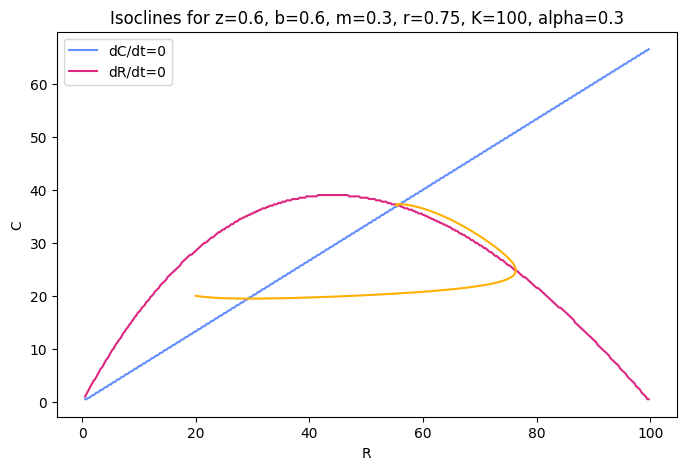

In [77]:
def simulate(R, C, N, dt, z, b, m, r, K, alpha, response=lambda R: 1.0):
    assert b * z - m > 0, 'Mortality is too high for the consumer to survive'

    R_array, C_array = [], []
    for _ in range(N):
        F = C / R
        R_array.append(R)
        C_array.append(C)
        dR = (r * (1 - R/K) * R - response(R) * z / (1 + alpha * F) * C) * dt 
        dC = (b * response(R) * z / (1 + alpha * F) * C - m * C) * dt

        R = max(0, R + dR)
        C = max(0, C + dC)
    
    return pd.DataFrame({'R': R_array, 'C': C_array, 't': np.arange(N) * dt})

df = simulate(R=20, C=20, N=1000, dt=0.1, z=z, b=b, m=m, r=r, K=K, alpha=alpha)

plt.figure(figsize=(8, 5))
sns.lineplot(x='R', y='C', data=isoclines[isoclines['case'] == 'C'], color=COLOR_PALETTE[0], label="dC/dt=0")
sns.lineplot(x='R', y='C', data=isoclines[isoclines['case'] == 'R'], color=COLOR_PALETTE[2], label="dR/dt=0")
plt.plot(df['R'], df['C'], color=COLOR_PALETTE[4], label="Simulated Trajectory")
plt.title(f"Isoclines for z={z}, b={b}, m={m}, r={r}, K={K}, alpha={alpha}");

Where the yellow line is the trajectory of our populations starting at $R=20,C=20$. Because this trajectory ends at the intersection of the two isoclines it will stay at that point forever more as both $dR/dt$ and $dC/dt$ are zero. The trajectory reaches a stable equilibrium. 

This shows us where one starting point ends up. What of the other starting points?

100%|██████████| 69/69 [00:05<00:00, 12.60it/s]


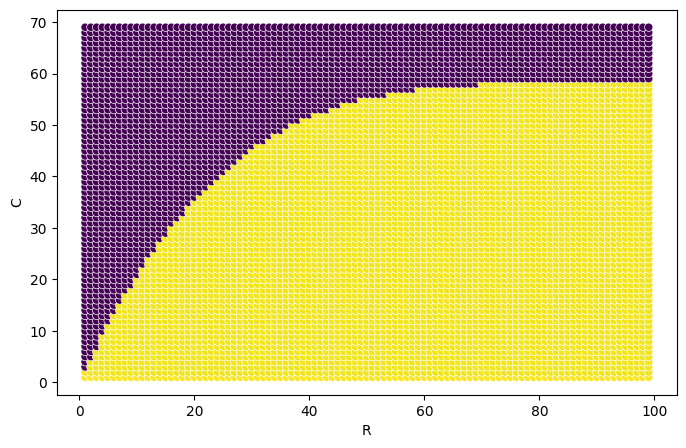

In [87]:
rows = []
for C in tqdm(range(1, 70, 1)):
    for R in range(1, 100, 1):
        df = simulate(R=R, C=C, N=1000, dt=0.1, z=z, b=b, m=m, r=r, K=K, alpha=alpha)
        rows.append({
            'C': C,
            'R': R,
            # distance from (0, 0)
            'u': np.sqrt(df['R'].values[-1] ** 2 + df['C'].values[-1] ** 2) 
        })
df = pd.DataFrame(rows)

plt.figure(figsize=(8, 5))
sns.scatterplot(x='R', y='C', data=df, hue='u', palette='viridis', legend=False);

Here the color of each of these points is determined by their trajectory's destination's distance from the origin. The yellow means starting at those points resulted in arriving at the same point as the trajectory above. Purple means the populations drove themselves to (0, 0).

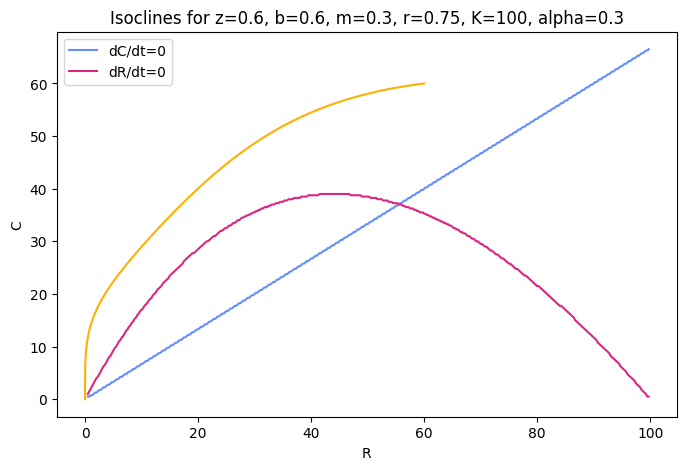

In [88]:
df = simulate(R=60, C=60, N=1000, dt=0.1, z=z, b=b, m=m, r=r, K=K, alpha=alpha)

plt.figure(figsize=(8, 5))
sns.lineplot(x='R', y='C', data=isoclines[isoclines['case'] == 'C'], color=COLOR_PALETTE[0], label="dC/dt=0")
sns.lineplot(x='R', y='C', data=isoclines[isoclines['case'] == 'R'], color=COLOR_PALETTE[2], label="dR/dt=0")
plt.plot(df['R'], df['C'], color=COLOR_PALETTE[4], label="Simulated Trajectory")
plt.title(f"Isoclines for z={z}, b={b}, m={m}, r={r}, K={K}, alpha={alpha}");

Here is an example of one such trajectory that drives itself to oblivion. We can see that the predator doesn't die off fast enough to allow the trajectory to fall below the purple line again. 

In summary in this model if our predator reaches high enough levels relative to the prey abundance it can drive both the prey and itself to extinction. 

Worryingly however there is a great deal of "delicate balance" hidden here. Let us drop $m$ by less than 10% to 0.27

100%|██████████| 69/69 [00:05<00:00, 13.50it/s]


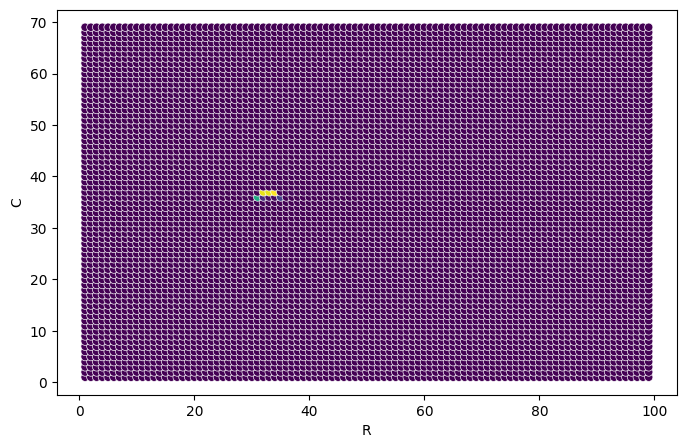

In [95]:
m = 0.27

rows = []
for C in tqdm(range(1, 70, 1)):
    for R in range(1, 100, 1):
        df = simulate(R=R, C=C, N=1000, dt=0.1, z=z, b=b, m=m, r=r, K=K, alpha=alpha)
        rows.append({
            'C': C,
            'R': R,
            # distance from (0, 0)
            'u': np.sqrt(df['R'].values[-1] ** 2 + df['C'].values[-1] ** 2) 
        })
df = pd.DataFrame(rows)

plt.figure(figsize=(8, 5))
sns.scatterplot(x='R', y='C', data=df, hue='u', palette='viridis', legend=False);

Suddenly almost the whole space leads to extinction! 

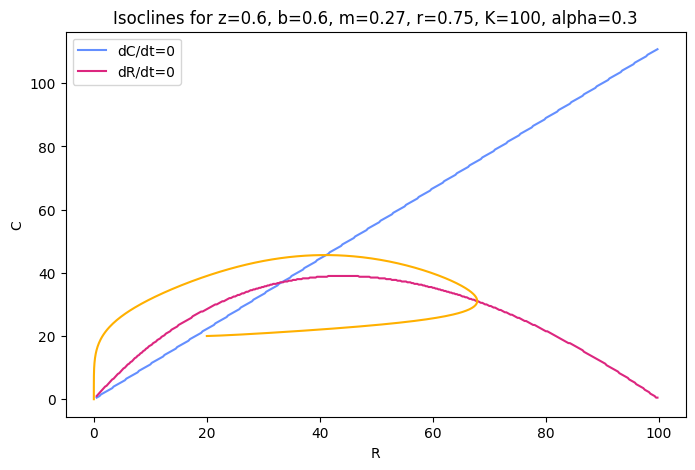

In [97]:
df = simulate(R=20, C=20, N=1000, dt=0.1, z=z, b=b, m=m, r=r, K=K, alpha=alpha)
isoclines = build_isoclines(C_range=(0.5, 200, 0.25), R_range=(0.5, 100, 0.25), z=z, b=b, m=m, r=r, K=K, alpha=alpha)

plt.figure(figsize=(8, 5))
sns.lineplot(x='R', y='C', data=isoclines[isoclines['case'] == 'C'], color=COLOR_PALETTE[0], label="dC/dt=0")
sns.lineplot(x='R', y='C', data=isoclines[isoclines['case'] == 'R'], color=COLOR_PALETTE[2], label="dR/dt=0")
plt.plot(df['R'], df['C'], color=COLOR_PALETTE[4], label="Simulated Trajectory")
plt.title(f"Isoclines for z={z}, b={b}, m={m}, r={r}, K={K}, alpha={alpha}");

Our previously stable point of $R=20,C=20$ causes such a growth in the predator that it then drives itself to high enough 
levels to cause mutual extinction. 

Is there some way we can stabilize this interaction? 